## Import Libraries

In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

## Set Computational Device

In [91]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)

cpu


## Data Pre-Processing

#### Import Data

In [92]:
# data = pd.read_csv('../data/ECONOMICS_USCSHPIMM, 1M.csv')

In [93]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

#### Inspect and Reshape Data

In [94]:
# Check layout
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [95]:
# Check for missing data points
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [96]:
# Convert time to datetime
data['time'] = pd.to_datetime(data['time'], unit = 's')
data = data.set_index('time')
data.head()

,close
time,
2000-02-01,0.8
2000-03-01,1.2
2000-04-01,1.5
2000-05-01,1.6
2000-06-01,1.5


In [97]:
# Convert to Numpy Array for further processing
data_raw = np.array(data).reshape(-1,1)

#### Data Visualization - Plot Data

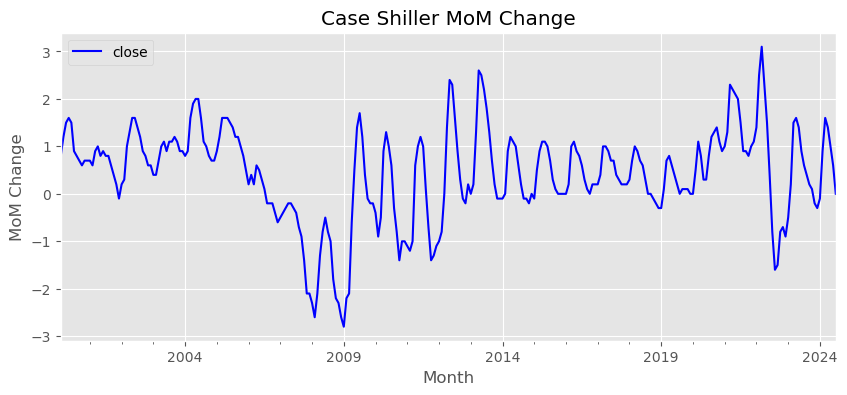

In [98]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

#### Find Seasonal Component

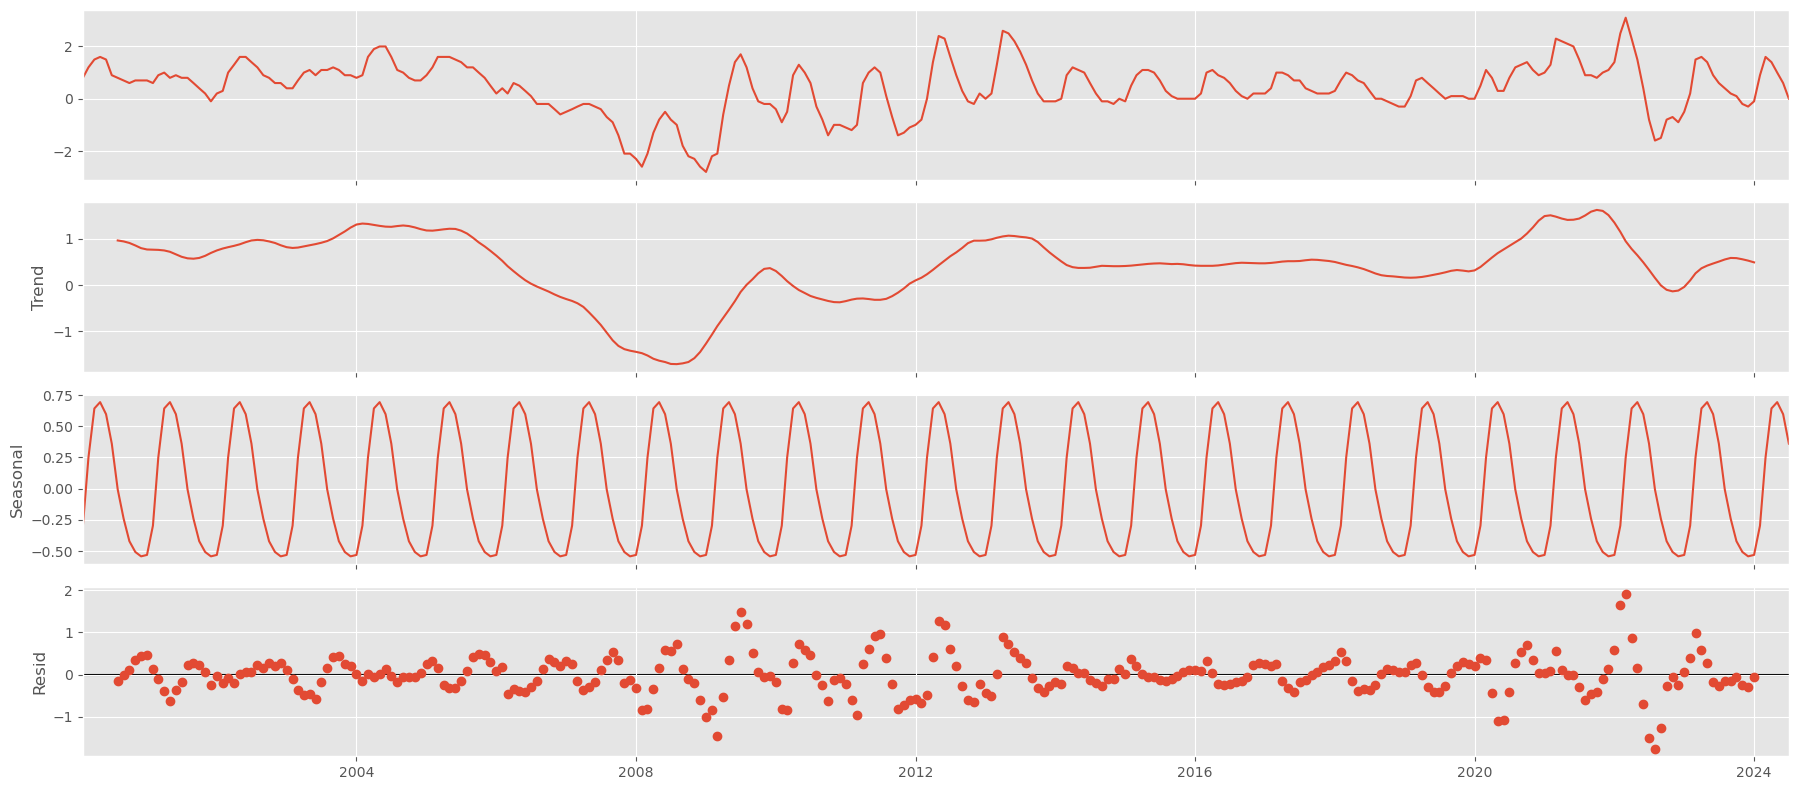

In [99]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

In [100]:
# Calculate seasonal component length, used to determine train/test split

seasonal_points = np.array(decomposition.seasonal)
# troughs = np.flatnonzero(seasonal_points == np.min(seasonal_points))
# seasonal_length = troughs[1] - troughs[0]
seasonal_length = np.flatnonzero(seasonal_points == np.min(seasonal_points))[1] - np.flatnonzero(seasonal_points == np.min(seasonal_points))[0]

#### Normalize data

In [101]:
# Choose Scaler to use:
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

In [102]:
# Scale Data
data_scaled = scaler.fit_transform(data_raw)
data_scaled.shape

(294, 1)

#### Plot Normalized Data

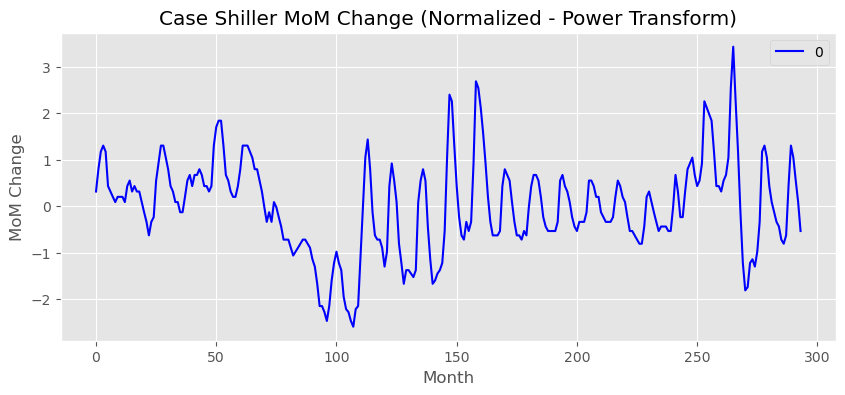

In [103]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

#### Train/Test Split

In [104]:
# Split data using 2 seasonal cycles of data to predict
cycles_to_predict = 2

# Calculate train/test split
split = len(data) - (cycles_to_predict * seasonal_length )

# Length of sequences to predict
n_input = len(data) - split

# Target sequence values used to calculate performance metrics 
data_targets = data.to_numpy()[split:]

# Create train and test data sets
train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(270, 1)
(24, 1)


#### Convert to Sequences

In [105]:
# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

## Training Set-up (Shared Across Models)

#### Training Parameters

In [106]:
n_features = 1
batch_size = 10
epochs = 200
n_runs = 3

#### Dataset and Dataloader

In [107]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

#### Train Model Function

In [108]:
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Early Stopping Parameters
    patience = 50
    min_delta = 0.00005
    val_losses = []

    for epoch in range(epochs):
        exit_loop = False
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            # Early Stopping Check 
            if epoch > 10 and loss.item() + min_delta >= max(val_losses[-patience:]):
                print(f"Early stopping at Epoch {epoch+1} with loss: {loss.item():.4f}. Last loss used from Epoch {epoch}: {val_losses[-1]}")
                exit_loop = True
                break
            loss.backward()
            optimizer.step()
        
        if exit_loop:
            break

        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
        # Early Stopping Check (maybe go before back propogate a higher loss? i.e. before loss.backward() above)
        # if epoch > 10 and loss.item() + min_delta >= max(val_losses[-patience:]):
        #     print(f"Early stopping at Epoch {epoch+1} with loss: {loss.item():.4f}")
        #     exit_loop = True
        #     break

        val_losses.append(loss.item())

#### Performance Evaluation Metrics Function

In [109]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

## Vanilla LSTM

#### Define LSTM Model

In [110]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Vanilla LSTM Training

In [111]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/200], Loss: 0.4585
Epoch [50/200], Loss: 0.4731
Epoch [75/200], Loss: 0.2721
Early stopping at Epoch 100 with loss: 0.7121. Last loss used from Epoch 99: 0.4968808889389038
Epoch [25/200], Loss: 0.7461
Epoch [50/200], Loss: 0.3914
Epoch [75/200], Loss: 0.4055
Early stopping at Epoch 93 with loss: 0.5611. Last loss used from Epoch 92: 0.5342826843261719
Epoch [25/200], Loss: 0.7829
Epoch [50/200], Loss: 0.4887
Epoch [75/200], Loss: 0.3041
Epoch [100/200], Loss: 0.3773
Epoch [125/200], Loss: 0.3430
Early stopping at Epoch 129 with loss: 0.6345. Last loss used from Epoch 128: 0.3224221467971802


#### Vanilla LSTM Predictions

In [112]:
print(final_vanilla.shape)
print(final_vanilla)

(24,)
[-1.036623   -0.968446   -0.7866779  -0.34774875  0.50161586  1.5090677
  1.94893256  1.68358491  1.03897909  0.2197086  -0.33958065 -0.70003928
 -0.90187946 -0.90495632 -0.6492616  -0.22161168  0.54220919  1.27885276
  1.72184743  1.6135453   1.05124621  0.35180093 -0.1475786  -0.34882499]


#### Export Data

In [113]:
np.savetxt("CSMoM_Vanilla_LSTM_Predictions.csv", final_vanilla, fmt='%f', delimiter=",")

#### Vanilla LSTM Predictions Visualization

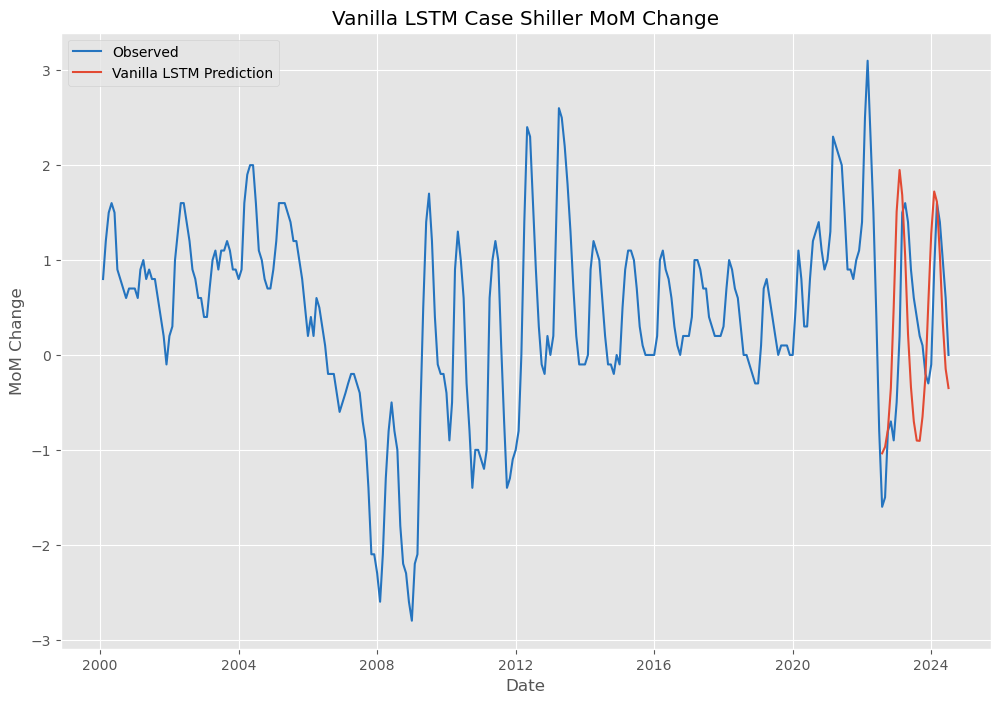

In [114]:
# line plot of observed vs predicted
rcParams['figure.figsize'] = 12, 8
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Vanilla LSTM Performance Metrics

In [115]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 1.82, 'RMSE': 1.35, 'MAPE': 3842.25}

## Stacked LSTM


#### Define Stacked LSTM Model

In [116]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.2 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Stacked LSTM Training

In [117]:
# Train and predict multiple times
store2 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)

Epoch [25/200], Loss: 0.6479
Epoch [50/200], Loss: 0.1628
Epoch [75/200], Loss: 0.0634
Epoch [100/200], Loss: 0.0265
Early stopping at Epoch 111 with loss: 0.2029. Last loss used from Epoch 110: 0.12458288669586182
Epoch [25/200], Loss: 0.4741
Epoch [50/200], Loss: 0.2478
Epoch [75/200], Loss: 0.0706
Epoch [100/200], Loss: 0.2269
Early stopping at Epoch 102 with loss: 0.2310. Last loss used from Epoch 101: 0.10698053985834122
Epoch [25/200], Loss: 0.4934
Epoch [50/200], Loss: 0.1227
Epoch [75/200], Loss: 0.0374
Early stopping at Epoch 95 with loss: 0.2857. Last loss used from Epoch 94: 0.06523880362510681


#### Stacked LSTM Predictions

In [118]:
print(final_stacked)
print(final_stacked.shape)

[-0.90842002 -0.70781596 -0.6895661  -0.70299945 -0.18925379  1.13307239
  1.95312324  1.94010234  1.51548246  0.91169053  0.15940363 -0.22909214
 -0.35513935 -0.32152071 -0.33769748 -0.31756325  0.37765956  1.41045935
  1.95219272  1.80081408  1.34105938  0.67205536  0.07445046 -0.24415087]
(24,)


#### Export Data

In [119]:
np.savetxt("CSMoM_Stacked_LSTM_Predictions.csv", final_stacked, fmt='%f', delimiter=",")

#### Stacked LSTM Predictions Visualization

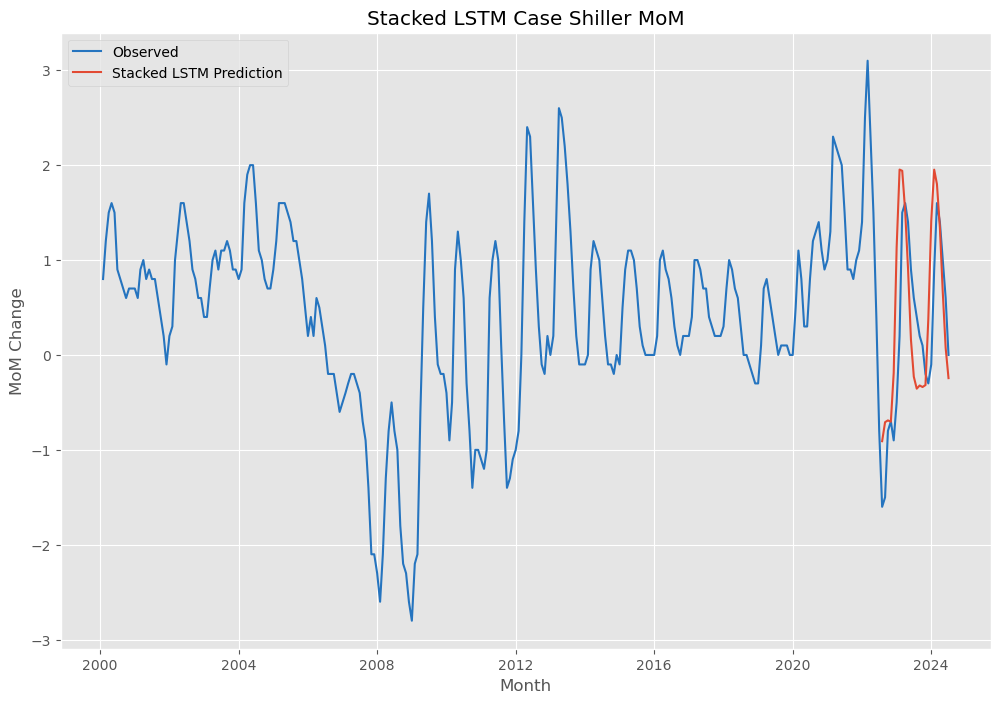

In [120]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Stacked LSTM Performance Metrics

In [121]:
stacked_lstm = performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 1.81, 'RMSE': 1.35, 'MAPE': 3740.09}

## Bidirectional LSTM

#### Define Bidirectional LSTM Model


In [122]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Bidirectional LSTM Training

In [123]:
# Train and predict multiple times
store3 = np.zeros((n_input, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_bidirec = BidirectionalLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_bidirec, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_bidirec(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store3[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_bidirec = np.mean(store3, axis=1)

Epoch [25/200], Loss: 0.4440
Epoch [50/200], Loss: 0.4050
Epoch [75/200], Loss: 0.3073
Epoch [100/200], Loss: 0.3819
Epoch [125/200], Loss: 0.3101
Early stopping at Epoch 132 with loss: 0.6010. Last loss used from Epoch 131: 0.31535783410072327
Epoch [25/200], Loss: 0.5236
Epoch [50/200], Loss: 0.6055
Epoch [75/200], Loss: 0.3379
Epoch [100/200], Loss: 0.3920
Epoch [125/200], Loss: 0.3269
Early stopping at Epoch 143 with loss: 0.5041. Last loss used from Epoch 142: 0.3510083258152008
Epoch [25/200], Loss: 0.4880
Epoch [50/200], Loss: 0.2240
Epoch [75/200], Loss: 0.2347
Epoch [100/200], Loss: 0.2108
Epoch [125/200], Loss: 0.3123
Epoch [150/200], Loss: 0.2642
Early stopping at Epoch 162 with loss: 0.3754. Last loss used from Epoch 161: 0.1698431521654129


#### Bidirectional LSTM Predictions

In [124]:
print(final_bidirec)
print(final_bidirec.shape)

[-0.96720231 -0.91264291 -0.75890588 -0.53606191 -0.05585532  1.01922407
  1.77854498  1.81637005  1.43558474  0.83002965  0.28506003 -0.07382634
 -0.30738349 -0.43047943 -0.40015436 -0.23577416  0.20219224  0.90002969
  1.5790256   1.7431345   1.3657576   0.85600385  0.27471461 -0.05736353]
(24,)


#### Export Data

In [125]:
np.savetxt("CSMoM_Bidirec_LSTM_Predictions.csv", final_bidirec, fmt='%f', delimiter=",")

#### Bidirectional LSTM Predictions Visualization

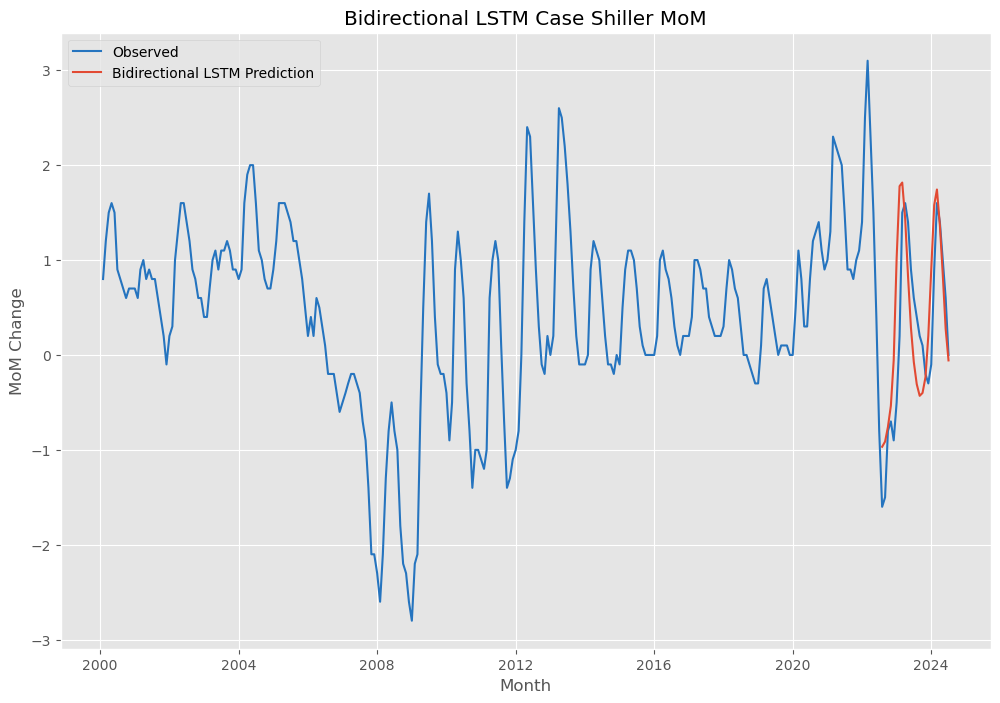

In [126]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

#### Bidirectional LSTM Performance Metrics

In [127]:
bidirec_lstm = performance(data_targets,final_bidirec)
bidirec_lstm

{'MSE': 1.67, 'RMSE': 1.29, 'MAPE': 3480.67}

## Compare Results

#### Evaluation Metrics

In [128]:
print(f"Vanilla LSTM: {vanilla_lstm}")
print(f"Stacked LSTM: {stacked_lstm}")
print(f"Bidirec LSTM: {bidirec_lstm}")
# print(f"Conv NN LSTM: {cnn}")

Vanilla LSTM: {'MSE': 1.82, 'RMSE': 1.35, 'MAPE': 3842.25}
Stacked LSTM: {'MSE': 1.81, 'RMSE': 1.35, 'MAPE': 3740.09}
Bidirec LSTM: {'MSE': 1.67, 'RMSE': 1.29, 'MAPE': 3480.67}


#### Visualization

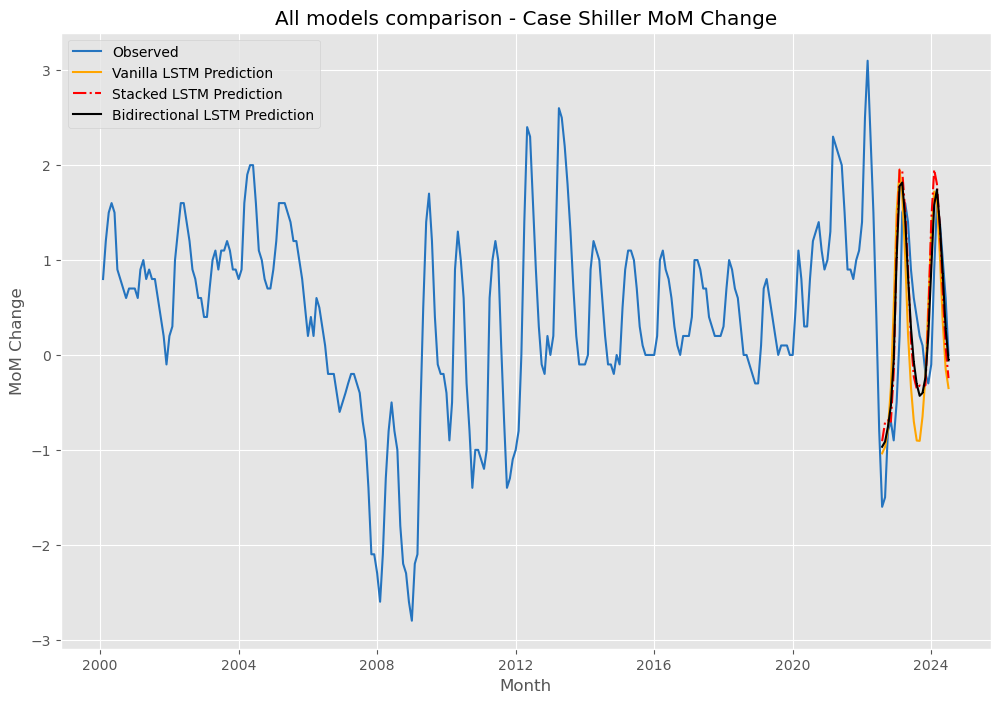

In [129]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction",linestyle= "-", color='orange')
#Stacked LSTM
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="red")
#Bidirectional LSTM
plt.plot(data[split:].index,final_bidirec,label="Bidirectional LSTM Prediction",marker=',',color='black')
#CNN model
# plt.plot(data[split:].index,final_cnn,label="CNN Prediction",marker="*",color="purple")
plt.title('All models comparison - Case Shiller MoM Change')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend(loc='upper left')
plt.show()